##Time series forecasting in TensorFlow (BitPredict)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

## What is a time series problem?

Time series problems deal with data over time.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).


## What we're going to cover

We've got a lot to go through.

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)


## Check for GPU

In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a7865524-2b8b-8dfc-ddf0-fa1d5edd04e6)


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

In [2]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-10-05 10:04:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-10-05 10:04:36 (5.16 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

 The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months).

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Ploting everything we've got.

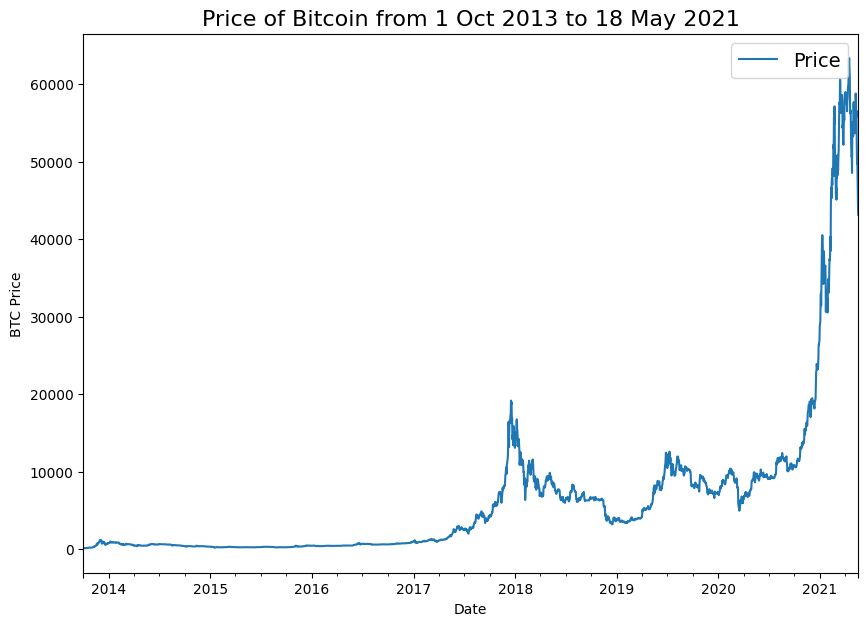

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

## Format Data Part 1: Creating train and test sets for time series data

What's the most important first step for preparing any machine learning dataset?

How about creating train and test splits?

Yes!

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`] but as we'll see in a moment, this doesn't really cut it for time series data.


### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable.

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize.

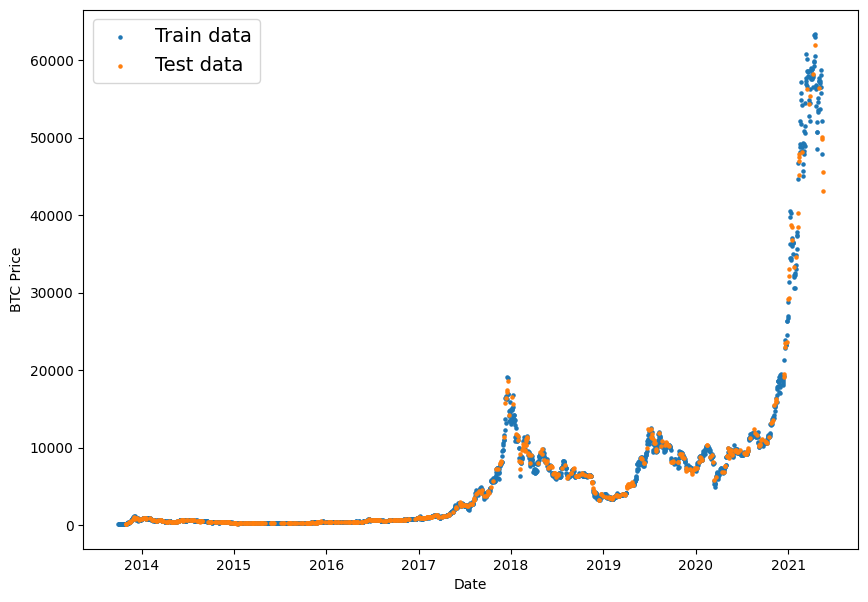

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)
To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

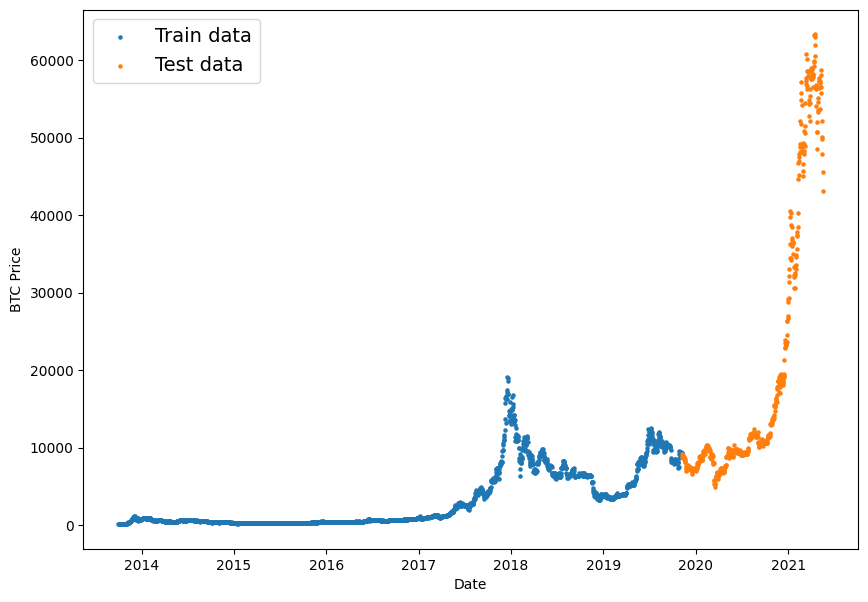

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

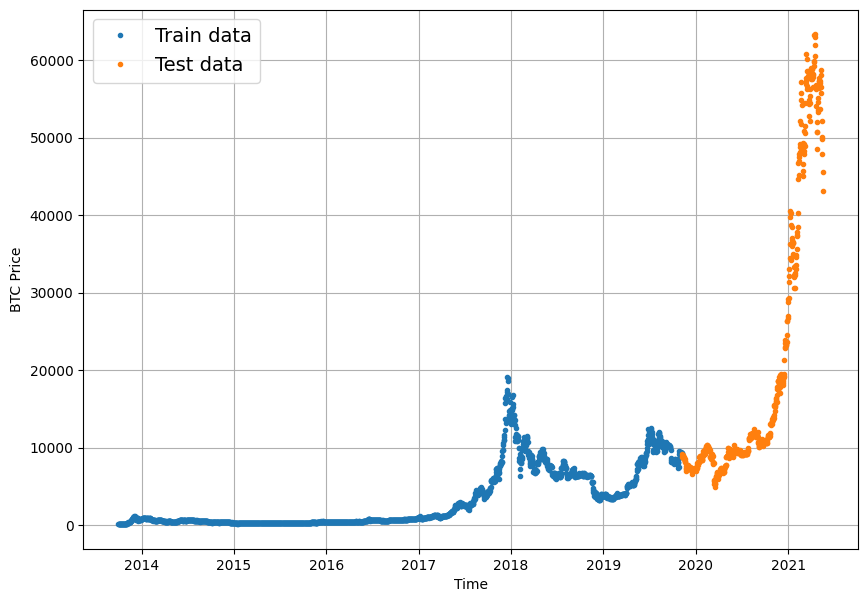

In [15]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Time for some modelling experiments.

## Modelling Experiments
Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | N-BEATs Algorithm | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|

## Model 0: Naïve forecast (baseline)
One of the most common baseline models for time series forecasting, the naïve model requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

 An **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [16]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

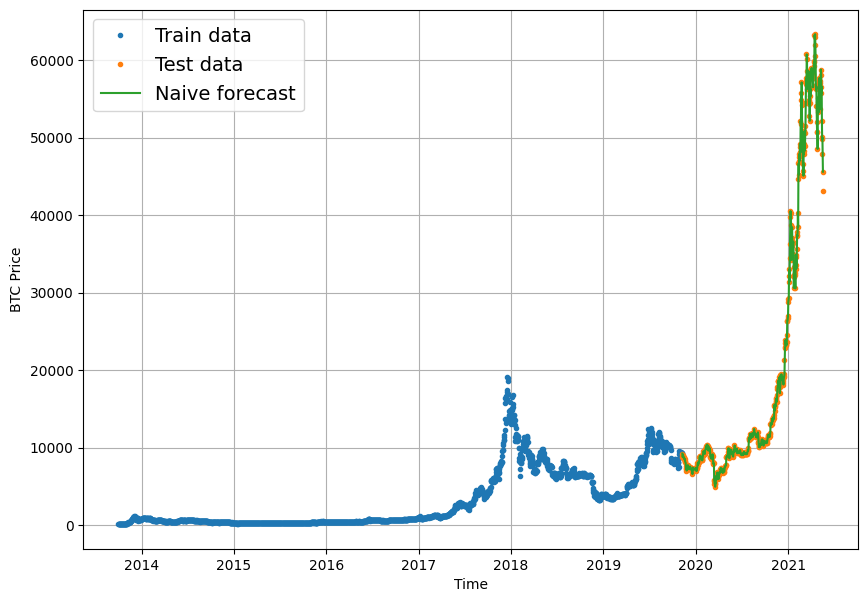

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

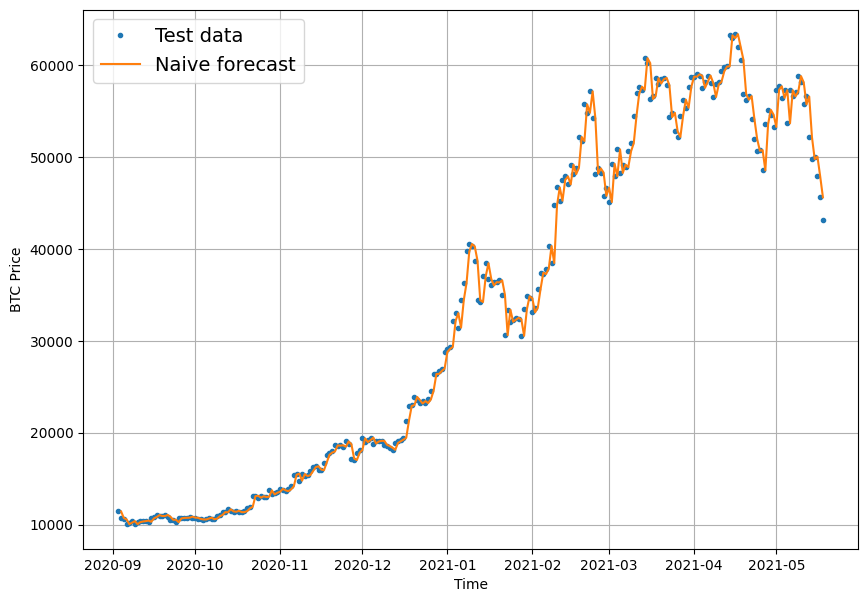

In [18]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

In [19]:
# Let's get TensorFlow!
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [21]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

How about we test our function on the naive forecast?

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [23]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

Only one more step (really two) to go.

I've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [24]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [25]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [26]:
 # Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [27]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [28]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [29]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [30]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [31]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels looks?

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [34]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint
We want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

 Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [35]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

Why these values?

I picked them out of experimentation.

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.
Let's import TensorFlow and build our first deep learning model for time series.

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 9s 104ms/step - loss: 4245.5312 - mae: 4245.5312 - val_loss: 14886.2783 - val_mae: 14886.2783
Epoch 2/100
18/18 [==============================] - 1s 51ms/step - loss: 954.3540 - mae: 954.3540 - val_loss: 3927.9475 - val_mae: 3927.9475
Epoch 3/100
18/18 [==============================] - 1s 45ms/step - loss: 385.1802 - mae: 385.1802 - val_loss: 1745.4384 - val_mae: 1745.4384
Epoch 4/100
18/18 [==============================] - 1s 61ms/step - loss: 237.1588 - mae: 237.1588 - val_loss: 1370.7430 - val_mae: 1370.7430
Epoch 5/100
18/18 [==============================] - 1s 54ms/step - loss: 223.7687 - mae: 223.7687 - val_loss: 1268.6359 - val_mae: 1268.6359
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 221.9295 - mae: 221.9295 - val_loss: 1227.5657 - val_mae: 1227.5657
Epoch 7/100
18/18 [==============================] - 1s 48ms/step - loss: 221.0019 - mae: 221.0019 - val_loss: 1195.5312 - val_mae: 1195.5312
E

Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [37]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 657.6375 - mae: 657.6375


[657.637451171875, 657.637451171875]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [38]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 572.7573 - mae: 572.7573


[572.7572631835938, 572.7572631835938]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which:
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [39]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Nice!

Now let's use our `make_preds()` and see how it goes.



In [40]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8868.611, 8801.197, 9030.338, 8733.088, 8749.907, 8758.008,
        8683.451, 8494.813, 8488.315, 8522.443], dtype=float32)>)

 With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [41]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 572.7572,
 'mse': 1172462.9,
 'rmse': 1082.8032,
 'mape': 2.5639338,
 'mase': 1.0061758}

How did our model go? Did it beat the naïve forecast?

In [42]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

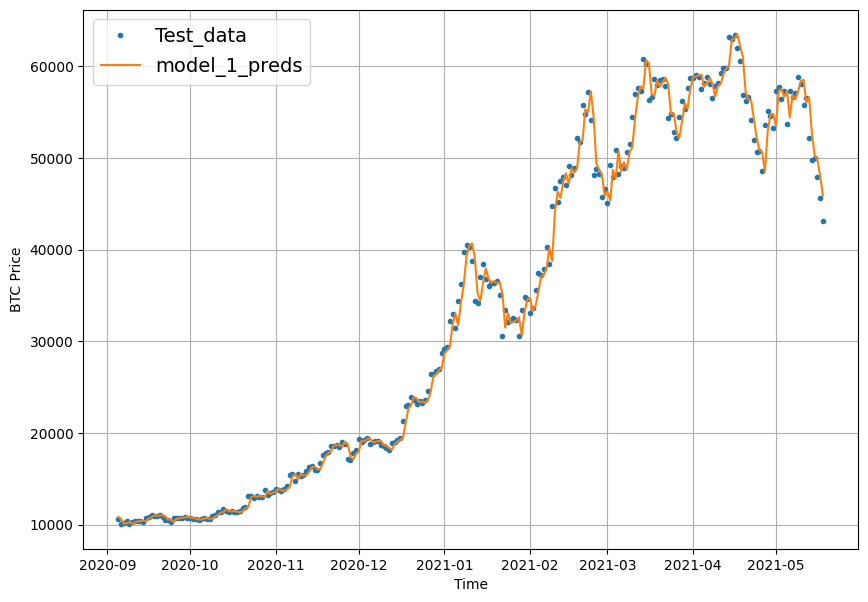

In [43]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model.

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

 Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [44]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [45]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [46]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [47]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [48]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 709.8691


709.8690795898438

Hmmm... is that the best it did?

How about we try loading in the best performing `model_2` which was saved to file thanks to our `ModelCheckpoint` callback.

In [49]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 611.2327


611.2327270507812

In [50]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [51]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 611.2327,
 'mse': 1270876.9,
 'rmse': 1127.3318,
 'mape': 2.7494152,
 'mase': 1.0684408}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

Does this mean a smaller window size is better? (I'll leave this as a challenge you can experiment with)

How do the predictions look?

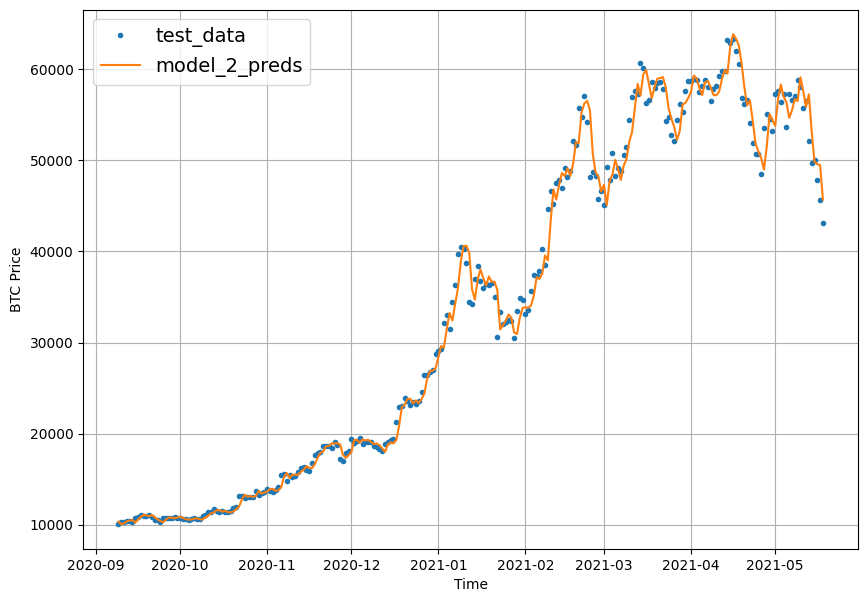

In [52]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [53]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

And we'll split the full dataset windows into training and test sets.

In [54]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

Now let's build, compile, fit and evaluate a model.

In [55]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [56]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1486.8838


1486.8837890625

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`.

In [57]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1254.3721


1254.3720703125

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [58]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9536.16  , 9626.311 , 9542.257 , 9434.613 , 9810.06  , 9507.9795,
        9823.429 ],
       [9001.0625, 9107.698 , 9261.938 , 9193.594 , 9409.74  , 9288.868 ,
        9292.503 ],
       [8583.191 , 8717.524 , 8938.253 , 8941.132 , 9032.861 , 9035.175 ,
        8985.35  ],
       [8726.259 , 8822.589 , 9080.54  , 8943.48  , 9122.876 , 9094.796 ,
        8985.853 ],
       [8828.172 , 8872.135 , 9001.445 , 9044.512 , 9143.399 , 9231.087 ,
        8956.101 ]], dtype=float32)>

In [59]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  818.3291  ,   470.9449  ,   328.4954  ,   341.4615  ,
          456.63086 ,   566.2416  ,   536.69543 ,   530.8822  ,
          479.32596 ,   631.3122  ,   825.87213 ,   922.7091  ,
          999.19885 ,   928.0888  ,   601.58734 ,   244.29172 ,
          237.08629 ,   178.80287 ,   230.89684 ,   215.94162 ,
          164.90256 ,   211.52274 ,   289.51486 ,   330.5817  ,
          190.92586 ,   122.11217 ,   142.84131 ,   125.86781 ,
          168.45627 ,   145.74512 ,   236.62709 ,   392.80484 ,
          355.0445  ,   314.1812  ,   295.9119  ,   267.06082 ,
          298.72406 ,   207.5491  ,   236.6084  ,   208.53062 ,
          381.4207  ,   129.10924 ,    60.474678,   115.140205,
           99.936386,   125.17948 ,    70.438545,    62.625767,
           86.45068 ,   148.66447 ,   174.12912 ,   106.71547 ,
          215.38826 ,   200.76709 ,   245.71834 ,   353.90805 ,
          586.59625 ,   561.0043  ,   531.5843  ,   497.68555 ,
          407.16156 ,   228.02762

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [60]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [61]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1254.372,
 'mse': 5516469.5,
 'rmse': 1434.8646,
 'mape': 5.642331,
 'mase': 2.232085}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

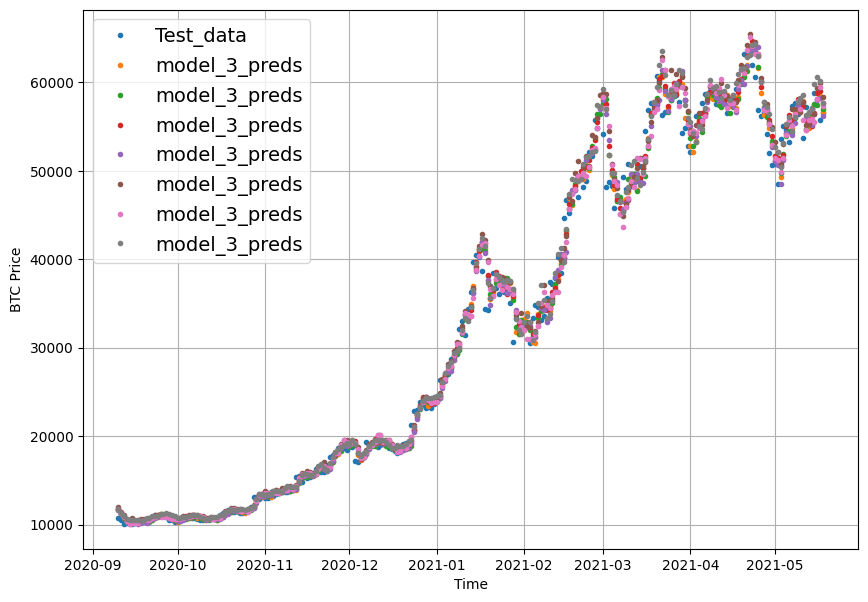

In [62]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

 Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

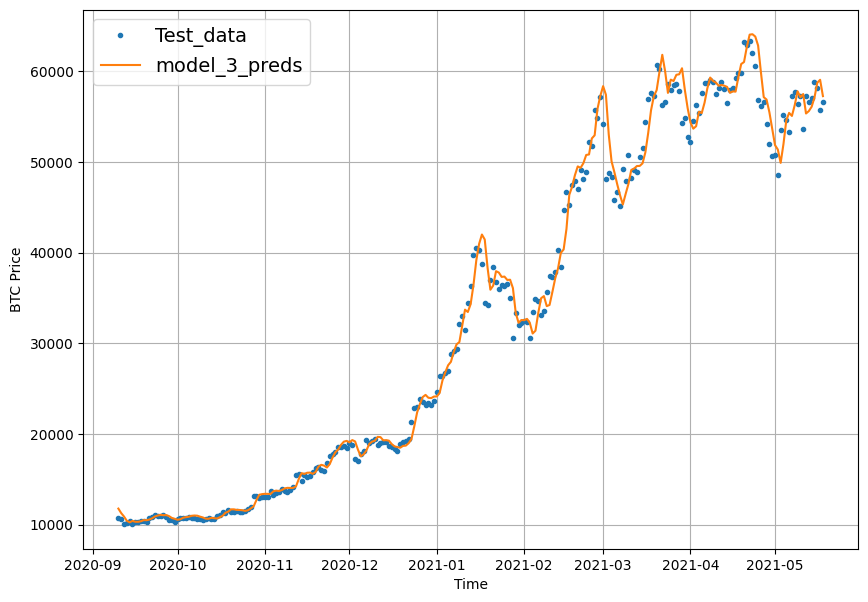

In [63]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

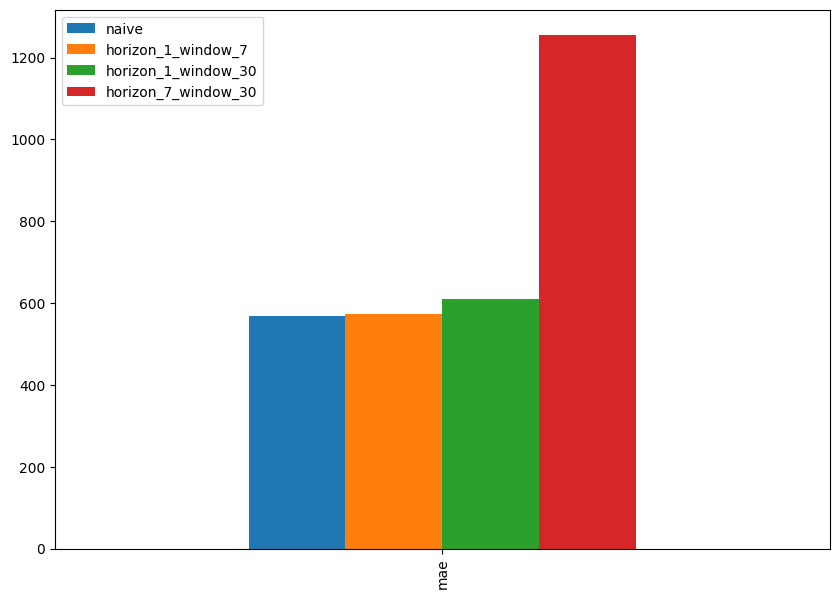

In [64]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

Why are the naïve results so good? One of the reasons could be due the presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.


## Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

Before we build a Conv1D model, let's recreate our datasets.

In [65]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [66]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [67]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [68]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [69]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [70]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

What does the Lambda layer look like in a summary?

In [71]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The Lambda layer appears the same as any other regular layer.

Time to evaluate the Conv1D model.

In [72]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 574.8777


574.8777465820312

In [73]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8905.912, 8787.474, 8975.679, 8801.787, 8748.484, 8723.399,
       8681.134, 8547.478, 8455.216, 8510.193], dtype=float32)>

In [74]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 574.87775,
 'mse': 1198465.5,
 'rmse': 1094.7445,
 'mape': 2.5776408,
 'mase': 1.0099009}

## Model 5: RNN (LSTM)

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.








In [75]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [76]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 589.9322


589.9321899414062

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [77]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8934.835 , 8799.789 , 8944.656 , 8794.698 , 8735.793 , 8718.509 ,
       8682.841 , 8547.284 , 8452.873 , 8498.8545], dtype=float32)>

In [78]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 589.9322,
 'mse': 1247157.0,
 'rmse': 1116.7618,
 'mape': 2.653253,
 'mase': 1.0363475}

LSTM-powered RNN we weren't able to beat our naïve models results.



## Make a multivariate time series

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

In [79]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) |

 Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [80]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

 For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [81]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [82]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


Woohoo! We've officially added another variable to our time series data.

Let's see what it looks like.

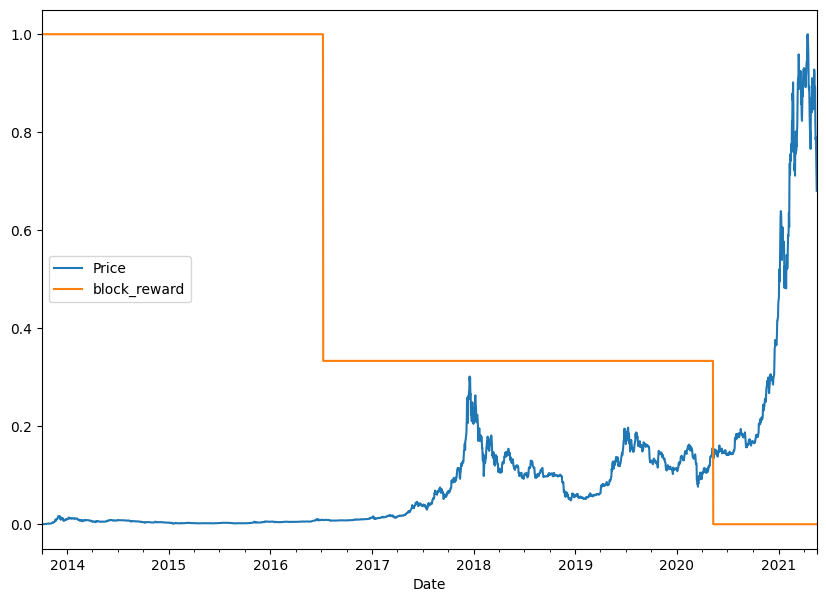

In [83]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [84]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [85]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [86]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [87]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

What a good looking dataset, let's split it into train and test sets using an 80/20 split just as we've done before.

In [88]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Training and test multivariate time series datasets made! Time to build a model.

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [89]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Multivariate model fit!

You might've noticed that the model inferred the input shape of our data automatically (the data now has an extra feature). Often this will be the case, however, if you're running into shape issues, you can always explicitly define the input shape using `input_shape` parameter of the first layer in a model.

Time to evaluate our multivariate model.

In [90]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 572.7892


572.7891845703125

In [91]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8837.36 , 8726.731, 9003.778, 8784.203, 8665.046, 8700.669,
       8680.597, 8483.505, 8418.915, 8503.737], dtype=float32)>

In [92]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 572.7891,
 'mse': 1178086.2,
 'rmse': 1085.3969,
 'mape': 2.5742395,
 'mase': 1.0062318}

how do these results compare to `model_1` (same window size and horizon but without the block reward feature)?

In [93]:
model_1_results

{'mae': 572.7572,
 'mse': 1172462.9,
 'rmse': 1082.8032,
 'mape': 2.5639338,
 'mase': 1.0061758}

The start date of our forecasted dates will be the last date of our dataset.

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far.

In [94]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results}).T
model_results.head(7)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,572.757202,1172462.875,1082.803223,2.563934,1.006176
model_2_dense_w30_h1,611.232727,1270876.875,1127.331787,2.749415,1.068441
model_3_dense_w30_h7,1254.371948,5516469.500,1434.864624,5.642331,2.232085
model_4_CONV1D,574.877747,1198465.500,1094.744507,2.577641,1.009901
model_5_LSTM,589.932190,1247157.000,1116.761841,2.653253,1.036348
model_6_multivariate,572.789124,1178086.250,1085.396851,2.574239,1.006232


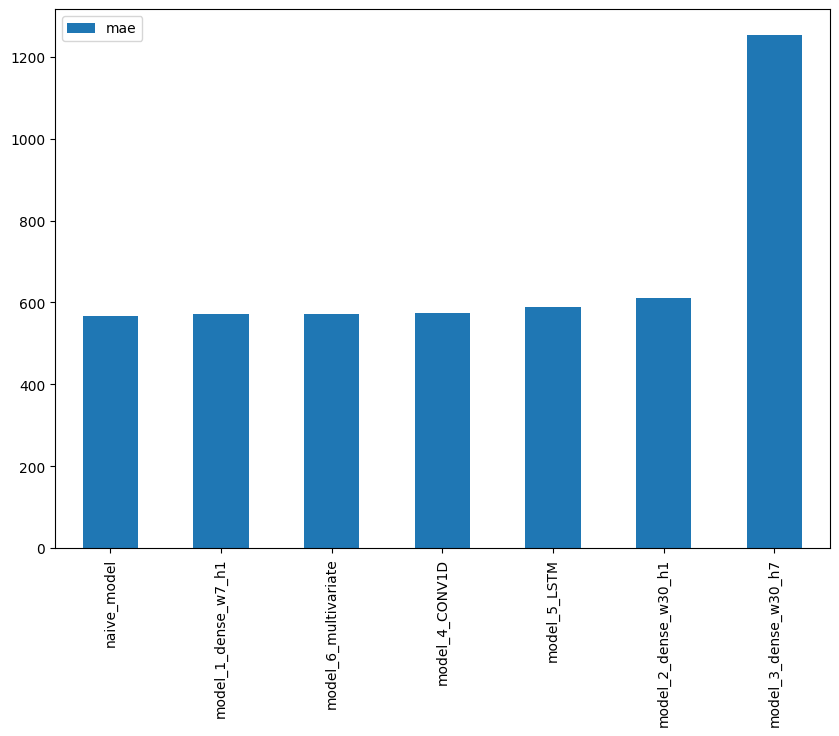

In [95]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");